In [ ]:
# ===================== THE REQUIRED TOOLS =====================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# ===================== LOAD DATA =====================

df_1 = pd.read_csv("data/Top250.csv")

In [26]:
# ===================== BASIC PROFILING =====================
df_1.info()
df_1.describe()
df_1.isna().sum()
df_1.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rank              250 non-null    int64 
 1   Restaurant        250 non-null    object
 2   Content           33 non-null     object
 3   Sales             250 non-null    int64 
 4   YOY_Sales         250 non-null    object
 5   Units             250 non-null    int64 
 6   YOY_Units         250 non-null    object
 7   Headquarters      52 non-null     object
 8   Segment_Category  250 non-null    object
dtypes: int64(3), object(6)
memory usage: 17.7+ KB


np.int64(0)

In [27]:
# ===================== DATA CLEANING =====================

df_1 = df_1.drop(columns=["Content", "Headquarters"])

df_1["YOY_Sales"] = df_1["YOY_Sales"].str.replace("%", "").astype(float) / 100
df_1["YOY_Units"] = df_1["YOY_Units"].str.replace("%", "").astype(float) / 100

df_1["Restaurant"] = df_1["Restaurant"].astype("string")
df_1["Segment_Category"] = df_1["Segment_Category"].astype("string")

df_1.columns = df_1.columns.str.lower()

df_1.isna().sum()


rank                0
restaurant          0
sales               0
yoy_sales           0
units               0
yoy_units           0
segment_category    0
dtype: int64

### Q1. Revenue concentration by segment
Identify which restaurant segments dominate total industry sales.


### Q2. High-growth segments
Compare revenue dominance with growth momentum across segments.


In [28]:
# ===================== QUESTION 1: TOP SEGMENTS BY SALES =====================
qstn1 = (
    df_1
    .groupby("segment_category")
    .agg(sum_sales=("sales", "sum"))
    .sort_values("sum_sales", ascending=False)
    .head(5)
)
qstn1


# ===================== QUESTION 2: FASTEST GROWING SEGMENTS =====================
qstn2 = (
    df_1
    .groupby("segment_category")
    .agg(avg_yoy_sales=("yoy_sales", "mean"))
    .sort_values("avg_yoy_sales", ascending=False)
    .head(5)
)
qstn2


,avg_yoy_sales
segment_category,
Fast Casual & Pizza,0.238000
Healthy,0.168000
Fast Casual & Burger,0.166500
Ethnic,0.119000
Quick Service & Beverage,0.112667


**Insight:**
Total sales are highly concentrated in a small number of large-scale segments, indicating that revenue leadership is driven primarily by network size and brand maturity.


**Insight:**
The fastest-growing segments differ from top revenue leaders, highlighting a trade-off between scale and growth potential.


### Q3. Does expansion drive revenue growth?
Test the relationship between unit growth and sales growth.


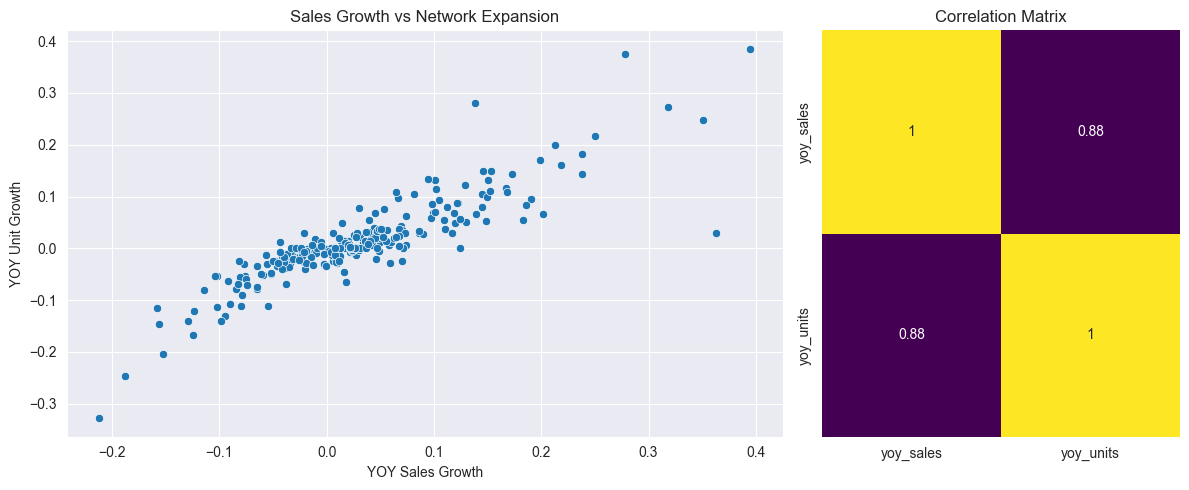

In [29]:
# ===================== QUESTION 3: SALES VS EXPANSION =====================
qstn3 = df_1[["yoy_sales", "yoy_units"]]
qstn3.corr()

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 5),
    gridspec_kw={"width_ratios": [2, 1]}
)

sns.scatterplot(data=qstn3, x="yoy_sales", y="yoy_units", ax=ax1)
ax1.set_title("Sales Growth vs Network Expansion")
ax1.set_xlabel("YOY Sales Growth")
ax1.set_ylabel("YOY Unit Growth")

sns.heatmap(qstn3.corr(), annot=True, cmap="viridis", cbar=False, ax=ax2)
ax2.set_title("Correlation Matrix")

plt.tight_layout()
plt.show()


**Insight:**
The correlation between expansion and sales growth is weak, suggesting that scaling alone does not guarantee revenue growth.


### Q4. Network size and efficiency
Evaluate how sales efficiency varies by network scale.


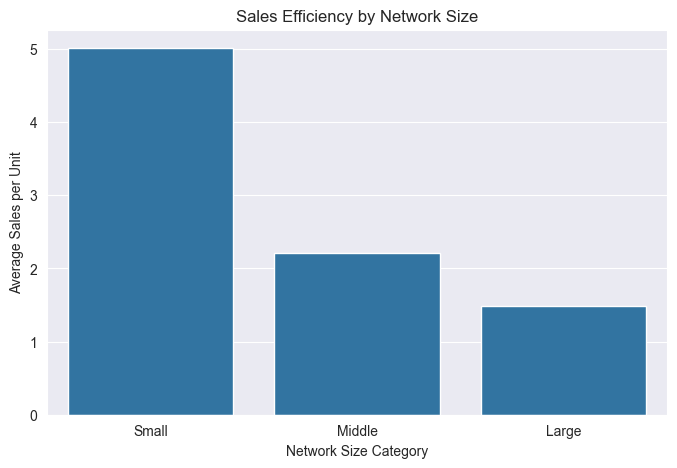

In [30]:
# ===================== QUESTION 4: EFFICIENCY VS NETWORK SIZE =====================

q25 = df_1["units"].quantile(0.25)
q50 = df_1["units"].quantile(0.50)

qstn4 = (
    df_1
    .assign(sales_per_unit=lambda x: x["sales"] / x["units"])
    .assign(
        size_category=lambda x: x.apply(
            lambda r: "Small" if r["units"] < q25 else
                      "Middle" if r["units"] < q50 else
                      "Large",
            axis=1
        )
    )
    .groupby("size_category")
    .agg(avg_efficiency=("sales_per_unit", "mean"))
    .sort_values("avg_efficiency", ascending=False)
)
qstn4

plt.figure(figsize=(8, 5))
sns.barplot(data=qstn4.reset_index(), x="size_category", y="avg_efficiency")
plt.title("Sales Efficiency by Network Size")
plt.xlabel("Network Size Category")
plt.ylabel("Average Sales per Unit")
plt.show()


**Insight:**
Smaller and mid-sized networks often demonstrate higher sales efficiency than large chains, indicating diminishing returns to scale.


### Q5. Growth strategy typology
Classify segments based on sales and expansion dynamics.


In [31]:
# ===================== QUESTION 5: GROWTH STRATEGY CLASSIFICATION =====================

qstn5 = (
    df_1
    .groupby("segment_category")
    .agg(
        avg_yoy_sales=("yoy_sales", "mean"),
        avg_yoy_units=("yoy_units", "mean"),
        total_sales=("sales", "sum"),
        total_units=("units", "sum")
    )
)

conditions = [
    (qstn5["avg_yoy_sales"] > 0) & (qstn5["avg_yoy_units"] > 0),
    (qstn5["avg_yoy_sales"] > 0) & (qstn5["avg_yoy_units"] <= 0),
    (qstn5["avg_yoy_sales"] <= 0) & (qstn5["avg_yoy_units"] > 0)
]

choices = [
    "Scaling / Expansion",
    "Efficiency-Driven Growth",
    "Risky Expansion"
]

qstn5["growth_type"] = np.select(
    conditions, choices,
    default="Decline / Stagnation"
)

qstn5[["growth_type"]]


,growth_type
segment_category,
Asian,Scaling / Expansion
Asian/Noodle,Decline / Stagnation
BBQ,Efficiency-Driven Growth
Bakery Cafe,Efficiency-Driven Growth
Burger,Decline / Stagnation
Casual Dining & Asian,Efficiency-Driven Growth
Casual Dining & Italian/Pizza,Efficiency-Driven Growth
Casual Dining & Seafood,Scaling / Expansion
Casual Dining & Sports Bar,Scaling / Expansion


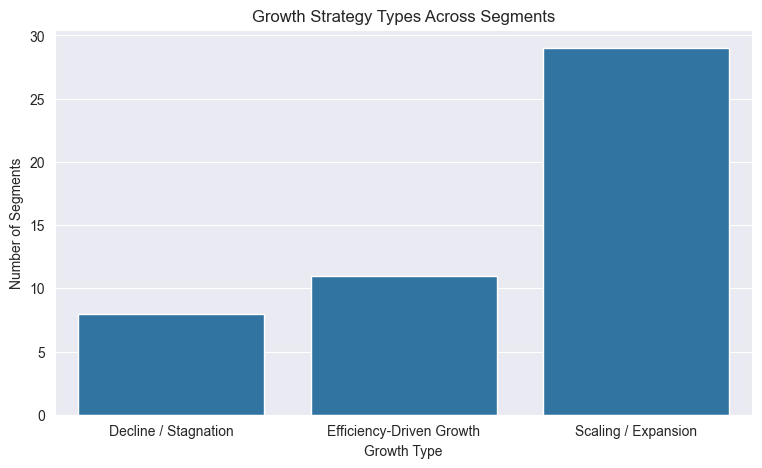

In [32]:
qstn5_plot = (
    qstn5
    .reset_index()
    .groupby("growth_type")
    .agg(count_segments=("segment_category", "count"))
)

plt.figure(figsize=(9, 5))
sns.barplot(
    data=qstn5_plot.reset_index(),
    x="growth_type",
    y="count_segments"
)
plt.title("Growth Strategy Types Across Segments")
plt.xlabel("Growth Type")
plt.ylabel("Number of Segments")
plt.show()


**Insight:**
Segments follow distinct growth paths: scaling-driven, efficiency-driven, or risky expansion, reinforcing that one-size-fits-all growth strategies are ineffective.


In [33]:
# ===================== LOAD DATA: Independence100 =====================
df_2 = pd.read_csv("data/Independence100.csv")


In [34]:
# ===================== PROFILING: Independence100 =====================
df_2.info()
df_2.describe()
df_2.isna().sum()
df_2.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rank           100 non-null    int64  
 1   Restaurant     100 non-null    object 
 2   Sales          100 non-null    float64
 3   Average Check  100 non-null    int64  
 4   City           100 non-null    object 
 5   State          100 non-null    object 
 6   Meals Served   100 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 5.6+ KB


np.int64(0)

In [35]:
# ===================== CLEANING & PREPARATION: Independence100 =====================
df_2["Restaurant"] = df_2["Restaurant"].astype("string")
df_2["City"] = df_2["City"].astype("string")
df_2["State"] = df_2["State"].astype("string")

df_2.columns = df_2.columns.str.lower().str.replace(" ", "_")

df_2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rank           100 non-null    int64  
 1   restaurant     100 non-null    string 
 2   sales          100 non-null    float64
 3   average_check  100 non-null    int64  
 4   city           100 non-null    string 
 5   state          100 non-null    string 
 6   meals_served   100 non-null    float64
dtypes: float64(2), int64(2), string(3)
memory usage: 5.6 KB


### Q6. Revenue drivers for independent restaurants
Assess whether pricing or volume has a stronger impact on sales.


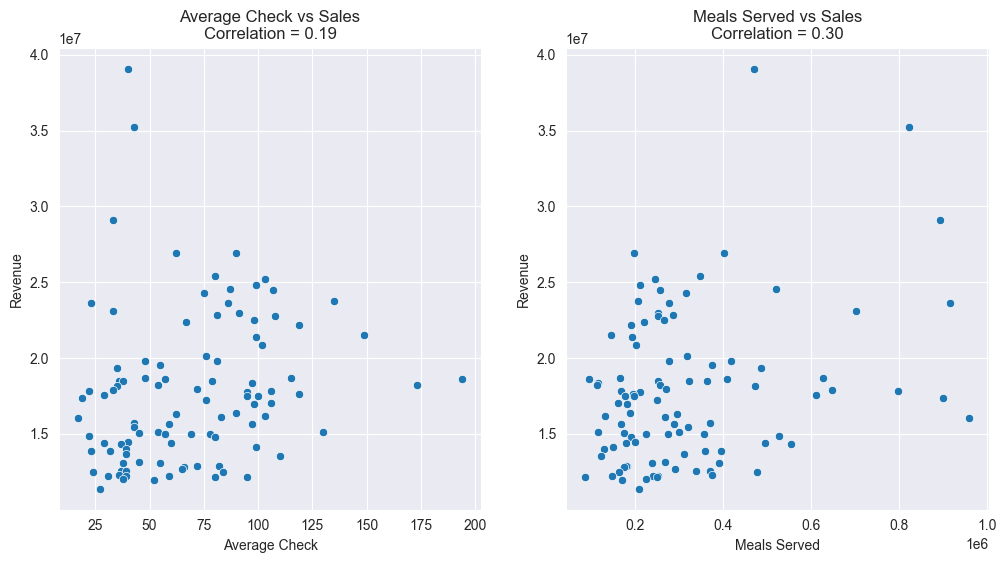

In [36]:
# ===================== Q6: DRIVERS OF SALES =====================
corr_ac = df_2["average_check"].corr(df_2["sales"])
corr_ms = df_2["meals_served"].corr(df_2["sales"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=df_2, x="average_check", y="sales", ax=ax1)
ax1.set_title(f"Average Check vs Sales\nCorrelation = {corr_ac:.2f}")
ax1.set_xlabel("Average Check")
ax1.set_ylabel("Revenue")

sns.scatterplot(data=df_2, x="meals_served", y="sales", ax=ax2)
ax2.set_title(f"Meals Served vs Sales\nCorrelation = {corr_ms:.2f}")
ax2.set_xlabel("Meals Served")
ax2.set_ylabel("Revenue")

plt.show()


**Insight:**
Sales are more strongly driven by volume (meals served) than pricing, emphasizing operational throughput over premium positioning.


### Q7. Pricing tiers and performance
Analyze how price positioning affects revenue-volume dynamics.


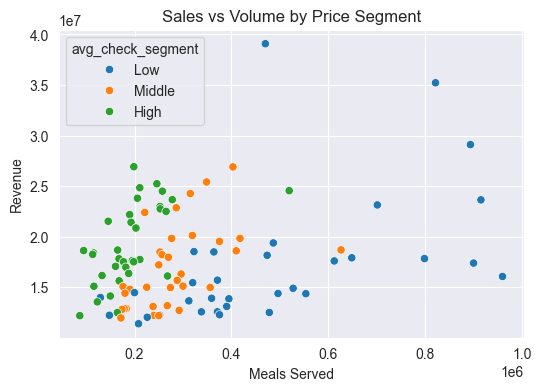

In [37]:
# ===================== Q7: PRICING SEGMENTS =====================
df_2["avg_check_segment"] = pd.qcut(
    df_2["average_check"],
    q=3,
    labels=["Low", "Middle", "High"]
)

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_2,
    x="meals_served",
    y="sales",
    hue="avg_check_segment"
)
plt.xlabel("Meals Served")
plt.ylabel("Revenue")
plt.title("Sales vs Volume by Price Segment")
plt.show()


**Insight:**
Higher average checks do not compensate for lower volume, suggesting limited scalability of premium pricing for independents.


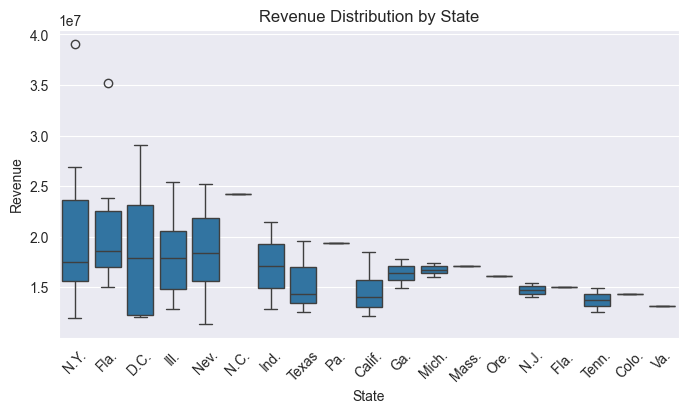

In [38]:
# ===================== Q8: GEOGRAPHIC EFFECT =====================
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_2, x="state", y="sales")
plt.xticks(rotation=45)
plt.xlabel("State")
plt.ylabel("Revenue")
plt.title("Revenue Distribution by State")
plt.show()


In [39]:
# ===================== LOAD DATA: Future50 =====================

df_3 = pd.read_csv("data/Future50.csv")

In [40]:
# ===================== PROFILING: Future50 =====================
df_3.info()
df_3.describe()
df_3.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rank         50 non-null     int64 
 1   Restaurant   50 non-null     object
 2   Location     50 non-null     object
 3   Sales        50 non-null     int64 
 4   YOY_Sales    50 non-null     object
 5   Units        50 non-null     int64 
 6   YOY_Units    50 non-null     object
 7   Unit_Volume  50 non-null     int64 
 8   Franchising  50 non-null     object
dtypes: int64(4), object(5)
memory usage: 3.6+ KB


Rank           0
Restaurant     0
Location       0
Sales          0
YOY_Sales      0
Units          0
YOY_Units      0
Unit_Volume    0
Franchising    0
dtype: int64

In [41]:
# ===================== CLEANING & PREPARATION: Future50 =====================
df_3["Restaurant"] = df_3["Restaurant"].astype("string")
df_3["Location"] = df_3["Location"].astype("string")
df_3["Franchising"] = df_3["Franchising"].astype("string")

df_3["YOY_Sales"] = df_3["YOY_Sales"].str.replace("%", "").astype(float) / 100
df_3["YOY_Units"] = df_3["YOY_Units"].str.replace("%", "").astype(float) / 100

df_3.columns = df_3.columns.str.lower().str.replace(" ", "_")

df_3[["city", "state"]] = df_3["location"].str.split(",", n=1, expand=True)
df_3["city"] = df_3["city"].str.strip()
df_3["state"] = df_3["state"].str.strip()

df_3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         50 non-null     int64  
 1   restaurant   50 non-null     string 
 2   location     50 non-null     string 
 3   sales        50 non-null     int64  
 4   yoy_sales    50 non-null     float64
 5   units        50 non-null     int64  
 6   yoy_units    50 non-null     float64
 7   unit_volume  50 non-null     int64  
 8   franchising  50 non-null     string 
 9   city         50 non-null     string 
 10  state        50 non-null     string 
dtypes: float64(2), int64(4), string(5)
memory usage: 4.4 KB


### Q9. Growth mechanics of emerging brands
Examine whether expansion translates into sales growth for fast-growing chains.


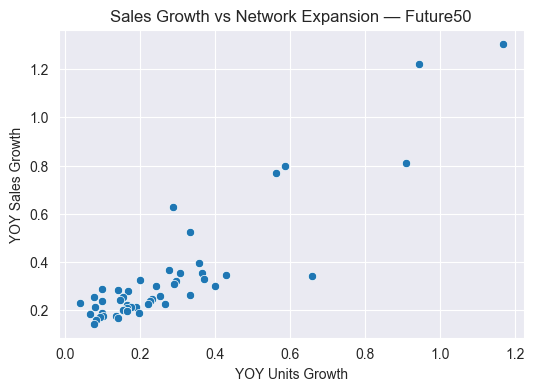

In [42]:
# ===================== Q9: GROWTH VS EXPANSION =====================
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_3, x="yoy_units", y="yoy_sales")
plt.xlabel("YOY Units Growth")
plt.ylabel("YOY Sales Growth")
plt.title("Sales Growth vs Network Expansion — Future50")
plt.show()


**Insight:**
Future50 brands show a clearer alignment between expansion and sales growth compared to mature chains, indicating an early-stage scaling effect.


### Q10. Franchising and growth
Compare growth dynamics between franchised and non-franchised models.


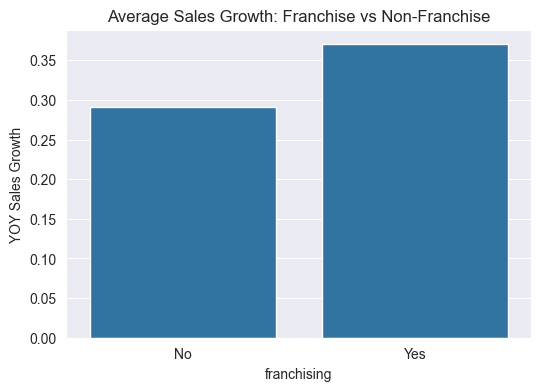

In [43]:
# ===================== Q10: FRANCHISING EFFECT =====================
qstn10 = (
    df_3
    .groupby("franchising")
    .agg(
        avg_yoy_sales=("yoy_sales", "mean"),
        avg_yoy_units=("yoy_units", "mean")
    )
    .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(data=qstn10, x="franchising", y="avg_yoy_sales")
plt.title("Average Sales Growth: Franchise vs Non-Franchise")
plt.ylabel("YOY Sales Growth")
plt.show()


**Insight:**
Franchised brands exhibit stronger average sales growth, suggesting franchising as an effective scaling mechanism for emerging chains.


### Q11. Unit economics and growth sustainability
Test whether high-performing units grow faster.


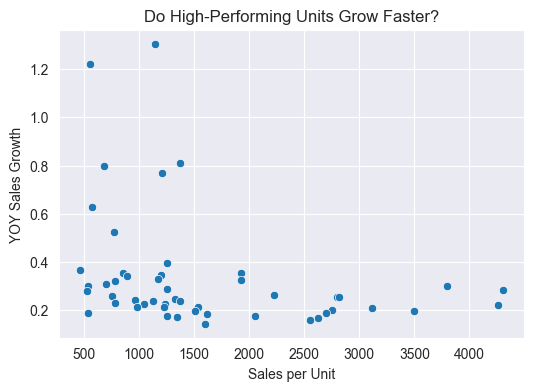

In [44]:
# ===================== Q11: UNIT ECONOMICS =====================
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_3, x="unit_volume", y="yoy_sales")
plt.xlabel("Sales per Unit")
plt.ylabel("YOY Sales Growth")
plt.title("Do High-Performing Units Grow Faster?")
plt.show()


**Insight:**
Higher unit-level performance is associated with stronger growth, supporting the role of unit economics in sustainable expansion.
